In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from scipy.special import binom
import sys
sys.path.append('../src/')
import utils.utils as utils
import utils.dataloader_utils as dataloader_utils
import os

%load_ext autoreload
%autoreload 2

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Step 0. Choose a vehicle trajectory and visualise it 

In [8]:
# A 5s vehicle trajectory represented with 5th polynomial
object_type = 'vehicle'
num_points_in_one_traj = 51 # 5s trajectory
deg = 5

In [9]:
file_name = 'data/preprocessed_data_example/training.tfrecord-00249-of-01000_00001_00001.json'

with open(file_name, "r") as read_file:
     data = json.load(read_file)

start_idx=20 # The whole trajectory is 9s, let's start at 2s and end at 7s
agt_traj = np.array(data['agt_traj'])[start_idx: start_idx+num_points_in_one_traj, [0,1]] # features are [x,y,z,heading,vx,vy] 
ego_traj = np.array(data['ego_traj'])[start_idx: start_idx+num_points_in_one_traj, [0,1]] # features are [x,y,z,heading,vx,vy] 

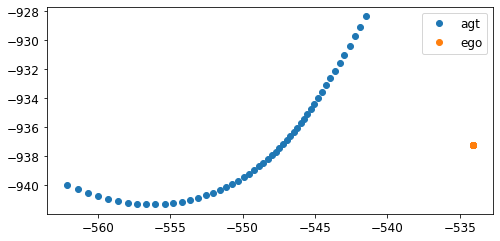

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(agt_traj[:,0], agt_traj[:,1], 'o', label='agt')
ax.plot(ego_traj[:,0], ego_traj[:,1], 'o', label='ego')
ax.legend()
ax.set_aspect('equal')

## Step 1. Build observation noise with prior

In [11]:
prior_folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_points_in_one_traj)
file_name = 'result_summary'

# Now we load our priors
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    prior = json.load(read_file)

A = np.array(prior['A_list'][deg-1]) # model parameter prior
B_d = np.array(prior['B_list'][deg-1]['B_d']) # coefficients for distance variance
B_theta = np.array(prior['B_list'][deg-1]['B_theta']) # angular variance
B_const = np.array(prior['B_list'][deg-1]['B_const']) # constant variance

A.shape, B_d.shape, B_theta.shape, B_const.shape

((10, 10), (3, 1), (1,), (1,))

In [12]:
# build up dataloader
list_dataset = dataloader_utils.generate_file_list_dataset('data/preprocessed_data_example/', outlier_list=[])
start_idx_dataset = tf.data.Dataset.from_tensor_slices([start_idx])

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(1, combined_dataset, num_points_in_one_traj, traj_type='agt_traj', with_heading=False)
dataProcessor.load_process(shuffle = False)

100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


In [13]:
for t_samples, traj_samples, d_norm_samples, theta_samples, R_samples in tqdm(dataProcessor.loaded_dataset):
    traj_samples = traj_samples.numpy()
    d_norm_samples = d_norm_samples.numpy()
    theta_samples = theta_samples.numpy()
    R_samples = R_samples.numpy()
    R = np.block([[tf.linalg.diag(R_samples[:, :, 0, 0]), tf.linalg.diag(R_samples[:, :, 0, 1])],
                  [tf.linalg.diag(R_samples[:, :, 1, 0]), tf.linalg.diag(R_samples[:, :, 1, 1])]])
    
    # Now we build up the observation noise
    phi_d = utils.expand(d_norm_samples, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))
    
    # Distance variance in polar coordinate
    var_d = np.squeeze(phi_d @ B_d)
    
    # Angular (alpha in paper) variance in polar coordinate
    var_theta =  B_theta
    
    # Transform covariance from polar to cartesian (ego)
    var_lon_lon = var_d * np.power(np.cos(theta_samples), 2) + var_theta *  np.power(d_norm_samples, 2) * np.power(np.sin(theta_samples), 2)
    var_lat_lat = var_d * np.power(np.sin(theta_samples), 2) + var_theta *  np.power(d_norm_samples, 2) * np.power(np.cos(theta_samples), 2)
    var_lon_lat = var_d * np.sin(theta_samples) * np.cos(theta_samples) - var_theta *  np.power(d_norm_samples, 2) * np.sin(theta_samples) * np.cos(theta_samples) 
    
    by_eye = np.array([[0,1],[1,0]])
    b_lon_lat_by_diag = np.kron(by_eye, tf.linalg.diag(var_lon_lat))
    
    # We add constant part to the covariance
    b_lon_lat_diag = tf.linalg.diag(tf.concat([var_lon_lon +B_const, var_lat_lat+B_const], axis = 1)).numpy()
    b_lon_lat = b_lon_lat_diag + b_lon_lat_by_diag
    
    # Rotate covariance from ego to world
    ob_cov = R @ b_lon_lat @ np.transpose(R, (0, 2, 1))# ob_cov is the observation covariance with shape [point_size*dim_size, point_size*dim_size]
    ob_cov = ob_cov[0] # squeeze the batch dimension

100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


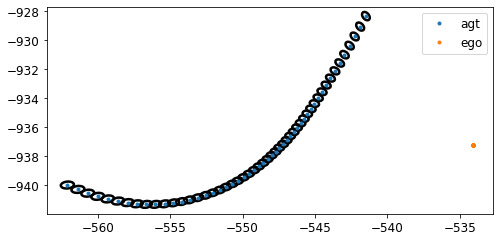

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(agt_traj[:,0], agt_traj[:,1], '.', label='agt')
ax.plot(ego_traj[:,0], ego_traj[:,1], '.', label='ego')
ax.legend()
ax.set_aspect('equal')

for i in range(0, num_points_in_one_traj):
    cov = np.array([[ob_cov[i,i], ob_cov[i,i+num_points_in_one_traj]], 
                    [ob_cov[i+num_points_in_one_traj,i], ob_cov[i+num_points_in_one_traj,i+num_points_in_one_traj]]])*25 # we enlarge the ob_cov for better visualization
    
    mean = agt_traj[i, [0,1]]
    utils.draw_confidence_ellipse(mean,cov, ax, lw=2.5)

## 2. Integrate model parameter prior with monomial basis function

In [17]:
# build monomial basis function without 0th parameter
phi_t_mono = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
phi_t_kron = np.kron(np.eye(2), phi_t_mono[:, :, 1:]) # we don't consider the 0th degree here
phi_t_kron.shape

(1, 102, 10)

In [18]:
# compute posterior 
phi_T_sigma_o = np.transpose(np.linalg.solve(ob_cov[None, :, :], phi_t_kron), (0,2,1))
sigma_post_inv =np.linalg.inv(A) + phi_T_sigma_o @ phi_t_kron
omega_post = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ traj_samples[:, :, None] # Posterior

posterior_traj = phi_t_kron @ omega_post 
posterior_traj = np.concatenate((posterior_traj[:, :num_points_in_one_traj], posterior_traj[:, num_points_in_one_traj:]), axis = 2)[0] # this trajectory start from (0,0) since we do not consider the 0th parameter
posterior_traj[:,0] = posterior_traj[:,0]+ agt_traj[0,0]
posterior_traj[:,1] = posterior_traj[:,1]+ agt_traj[0,1]

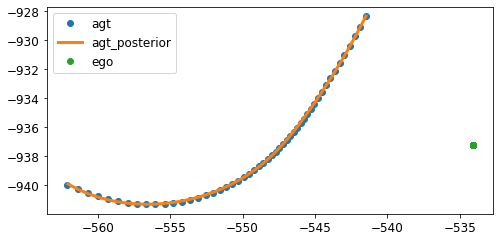

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(agt_traj[:,0], agt_traj[:,1], 'o', label='agt')
ax.plot(posterior_traj[:,0], posterior_traj[:,1], linewidth=3, label='agt_posterior')
ax.plot(ego_traj[:,0], ego_traj[:,1], 'o', label='ego')
ax.legend()
ax.set_aspect('equal')

## 3. Integrate model parameter prior with bernstein basis function

In [20]:
# Transform monomial basis function to bernstein basis function
M = np.zeros((deg+1, deg+1))
for k in range(0, deg + 1):
    for i in range(k, deg + 1):
        M[i, k] = (-1)**(i - k) * binom(deg, i) * binom(i, k)

phi_t_bern= phi_t_mono @ M
phi_t_kron_bern = np.kron(np.eye(2), phi_t_bern[:, :, 1:]) # we don't consider the 0th degree here


# Transform monomial prior to bernstein prior
M_inv = np.linalg.solve(M[1:, 1:], np.eye(deg))
monomial_scale = utils.polyBasisScale(t_samples[0,-1], deg)
monomial_scale = np.kron(np.eye(2), monomial_scale[1:,1:])
A_scaled = monomial_scale @ A @ monomial_scale.T # we need to scale the monomial prior to t=(0,1) to fit bernstein prior
bernstein_cov = np.kron(M_inv, np.eye(2)) @ A_scaled @ np.kron(M_inv, np.eye(2)).T

In [22]:
# compute posterior with bernstein basis function
phi_T_sigma_o = np.transpose(np.linalg.solve(ob_cov[None, :, :], phi_t_kron_bern), (0,2,1))
sigma_post_inv =np.linalg.inv(bernstein_cov) + phi_T_sigma_o @ phi_t_kron_bern
omega_post_bern = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ traj_samples[:, :, None] # Posterior

posterior_traj_bern = phi_t_kron_bern @ omega_post_bern 
posterior_traj_bern = np.concatenate((posterior_traj_bern[:, :num_points_in_one_traj], posterior_traj_bern[:, num_points_in_one_traj:]), axis = 2)[0] # this trajectory start from (0,0) since we do not consider the 0th parameter
posterior_traj_bern[:,0] = posterior_traj_bern[:,0]+ agt_traj[0,0]
posterior_traj_bern[:,1] = posterior_traj_bern[:,1]+ agt_traj[0,1]

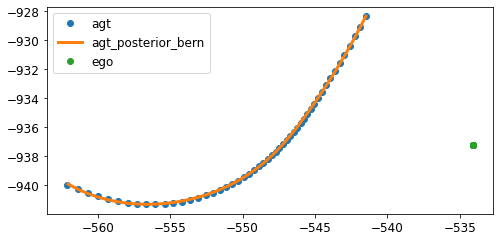

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(agt_traj[:,0], agt_traj[:,1], 'o', label='agt')
ax.plot(posterior_traj_bern[:,0], posterior_traj_bern[:,1], linewidth=3, label='agt_posterior_bern')
ax.plot(ego_traj[:,0], ego_traj[:,1], 'o', label='ego')
ax.legend()
ax.set_aspect('equal')